Maps for analogy to 1940s event:
Plot a full domain map of the 1982 forcing (v wind colors and mag quivers)
Also plot full domain map of the 1940s event in PACE2 reconstruction

Maps for analogy to ASL deepening trend: 
Full domain map of 1989 event (and/or trend?)
Full domain map of PACE2 recon trend

In [1]:
import Functions_data_analysis as fda
import Functions_load_output as flo
import Functions_plotting as fp
from Datasets import exp_set_dict_warm_order, exp_set_dict_wind_order

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import matplotlib.path as mpath

In [2]:
import importlib
importlib.reload(fda)

<module 'Functions_data_analysis' from '/glade/campaign/univ/ulnl0002/Gemma/Analysis/Functions_data_analysis.py'>

In [3]:
exp_set = 'ic_1995'
# region = 'AS_long'
region = 'AS_near'
# region = 'full_model_domain'

time_mean = 1995
# How many months of data to retrieve (from the first February of data)
n_months = 12

runs = exp_set_dict_warm_order[exp_set]
print('Using the following experiments in this order:\n',runs)

Using the following experiments in this order:
 ['run_forc_erai_1982_rep_ic_1995', 'run_forc_erai_1984_rep_ic_1995', 'run_forc_erai_1989_rep_ic_1995', 'run_forc_erai_1992_rep_ic_1995', 'run_forc_erai_1994_rep_ic_1995', 'run_forc_erai_2003_rep_ic_1995', 'run_forc_erai_2009_rep_ic_1995', 'run_forc_erai_1991_rep_ic_1995', 'run_forc_erai_2015_rep_ic_1995', 'run_forc_erai_2011_rep_ic_1995']


In [3]:
prefix = 'EXF_forcing_set2' 
all_run_uwind_da = fda.get_ensemble_data_for_ic('uwind', runs, region, prefix, n_months = n_months) 
all_run_vwind_da = fda.get_ensemble_data_for_ic('vwind', runs, region, prefix, n_months = n_months) 

Getting uwind data for all runs...
0
saving date from these times for 1st run:
 [cftime.DatetimeNoLeap(1995, 2, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1995, 3, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1995, 4, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1995, 5, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1995, 6, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1995, 7, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1995, 8, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1995, 9, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1995, 10, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1995, 11, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1995, 12, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1996, 1, 1, 0, 0, 0, 0, has_year_zero=True)]
(12, 254, 300)
1
(12, 254, 300)
2
(12, 254, 300)
3
(12, 254, 300)
4
(12, 254, 300)
5
(12, 254, 300)
6
(12, 254, 

In [ ]:
# GEt control run for reference
ctrl_uwind_da = fda.get_ensemble_data_for_ic('uwind', ['control'], region, prefix, n_months = 14*12) #1992-2005 
ctrl_vwind_da = fda.get_ensemble_data_for_ic('vwind', ['control'], region, prefix, n_months = 14*12) 

# remove run dimension since only 1 run
ctrl_uwind = ctrl_uwind_da.squeeze()
ctrl_vwind = ctrl_vwind_da.squeeze()

In [6]:
# Put forcings in anomalies relative to control run or mean fo 10 exps

anom_ref = 'ctrl'

# Calc time avg of ens data
uwind_time_avg = all_run_uwind_da.mean(dim='time')  #(n_runs,n_lats,n_lons)
vwind_time_avg = all_run_vwind_da.mean(dim='time')

if anom_ref == 'ctrl':
    ctrl_time_avg_u = ctrl_uwind_da.mean(dim='time')
    ctrl_time_avg_v = ctrl_vwind_da.mean(dim='time')
    # tile ctrl mean 10 times to subtract from ens data
    n_ens = uwind_time_avg.shape[0]
    tiled_uwind_ctrl_avg = np.tile(ctrl_time_avg_u, (n_ens,1,1))
    tiled_vwind_ctrl_avg = np.tile(ctrl_time_avg_v, (n_ens,1,1))
    uwind_anom = uwind_time_avg - tiled_uwind_ctrl_avg
    vwind_anom = vwind_time_avg - tiled_vwind_ctrl_avg
    
elif anom_ref == 'ens_mean':
    # Get ensemble means and em time-avg
    uwind_em = all_run_uwind_da.mean(dim = 'run')
    vwind_em = all_run_vwind_da.mean(dim = 'run')
    uwind_em_time_avg = uwind_em.mean(dim = 'time')
    vwind_em_time_avg = vwind_em.mean(dim = 'time')
    # calc anoms
    uwind_anom = uwind_time_avg - uwind_em_time_avg 
    vwind_anom = vwind_time_avg - vwind_em_time_avg

print('anomalies calculated relative to',anom_ref)

anomalies calculated relative to ctrl


In [7]:
# calc mag for each run
mag_ens_data = []
for i in range(len(uwind_anom)):
    mag_i = (uwind_anom[i] ** 2 + vwind_anom[i] ** 2) ** 0.5
    mag_ens_data.append(mag_i)
mag_ens_da = xr.concat(mag_ens_data,dim='run')

# #mask small values and large values (Nan where condition is met)
# mask = (mag_em < 0.01) | (mag_em > 0.1) # scale = .35
# mask = (mag_ens_da < 0.3) 
# uwind_masked = uwind_anom.where(~mask)
# vwind_masked = vwind_anom.where(~mask)

In [8]:
# set up data and params to plot
yr_idx = 9 #0 -->1982 for first run in warm_order
# 1982, 1984, 1989, 1992
# 2015, 2011 are 8, 9

# Plot v vel as colors
data_2d = vwind_anom[yr_idx]
levs = np.linspace(-0.5,0.5,11)
cmap = 'BrBG'
cbar_label = 'V wind anomalies [m/s]'

# Plot mags as colors
# data_2d = mag_ens_da[yr_idx]
# levs = np.linspace(0,2.2,11)
# cmap = 'Spectral_r'
# cbar_label = 'Wind speed anomalies [m/s]'

#Plot U vel as colors
# data_2d = uwind_anom[yr_idx]
# levs = np.linspace(-0.5,0.5,11)
# cmap = 'PuOr_r'
# cbar_label = 'U wind anomalies [m/s]'

data_x = uwind_anom[yr_idx]
data_y = vwind_anom[yr_idx]

title = runs[yr_idx].split('run_forc_erai_')[1][0:4]+'_x5'
print(title)
vec_len = 0.5

land_ice_ds = flo.get_bathymetry_and_troughs()

2011_x5


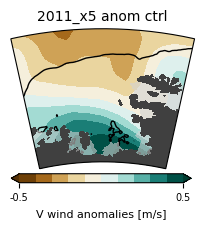

In [9]:
# Set up plot
region = 'AS_near' #scale 11, regrid 15
# region = 'full_model_domain' #scale 15, regrid 10

lons, lats = data_2d.lon, data_2d.lat
lat1,lat2,lon1,lon2 = fda.plot_regions[region]
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

fig = plt.figure()
fig.set_size_inches((3,2))
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid)) #eentral_lon =-100 rotates antarctica so pacific is up
data_2d_ma = data_2d.where(data_2d != 0)
cf_em = ax.contourf(lons, lats, data_2d_ma,transform=grid_proj,
                    levels=levs, cmap=cmap, zorder=0, extend = 'both')

plt.title(title + ' anom '+anom_ref, fontsize=10)
bathy_col = 'k' 
q_lon,q_lat = data_x.lon.values, data_x.lat.values
# smaller scale means longer arrows. smaller regrid = fewer arrows.
# quiv = ax.quiver(q_lon,q_lat, data_x.values, data_y.values,
#                  transform = grid_proj,regrid_shape=10,
#                  pivot = 'middle',scale=15,width=0.01,
#                  headlength=3,headaxislength=2.5,
#                  minshaft=1,edgecolor='white',
#                  linewidth = 0.2,zorder=3)
# ax.quiverkey(quiv, X=0.03, Y=0.25, U=vec_len, label=str(vec_len)+' m/s', labelpos='S')

# Add colorbar
cb_ax = fig.add_axes([0.22,0.08,0.6,0.045])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
cb_em.set_label(label = cbar_label, fontsize=8)
cb_em.ax.tick_params(labelsize=7)
cb_em.set_ticks([levs[0],levs[-1]])
cb_em.set_ticklabels([levs[0],levs[-1]])

# Plot bathyemtry and ice and plot
land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
lons,lats = land_ice_ds.lon, land_ice_ds.lat
#blevs = (500,1000)
#ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
# Uncomment to Plot shelf break in thicker line
ax.contour(lons,lats,land_ice_ds.bathy,(1000,),colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)

# Set shape of map to match shape of data rather than a rectangle
rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)
ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

fig.subplots_adjust(left=0.1,right=0.95,top=0.85,bottom=0.15,wspace=0.1,hspace=.05)


In [35]:
# set up data and params to plot composite


# Plot v vel as colors
# data_2d = np.mean(vwind_anom[0:4],axis=0) # warm
data_2d = np.mean(vwind_anom[5:9],axis=0) #cool 
print(vwind_anom[4:8].run)
levs = np.linspace(-0.3,0.3,11)
cmap = 'BrBG'
cbar_label = 'V wind anomalies [m/s]'


#Plot U vel as colors
# data_2d = uwind_anom[yr_idx]
# levs = np.linspace(-0.5,0.5,11)
# cmap = 'PuOr_r'
# cbar_label = 'U wind anomalies [m/s]'

data_x = np.mean(uwind_anom[0:4],axis=0)
data_y = np.mean(vwind_anom[0:4],axis=0)

title = 'Cool'
print(title)
vec_len = 0.5

land_ice_ds = flo.get_bathymetry_and_troughs()

<xarray.DataArray 'run' (run: 4)>
array(['run_forc_erai_1994_rep_ic_1995', 'run_forc_erai_2003_rep_ic_1995',
       'run_forc_erai_2009_rep_ic_1995', 'run_forc_erai_1991_rep_ic_1995'],
      dtype='<U30')
Coordinates:
  * run      (run) <U30 'run_forc_erai_1994_rep_ic_1995' ... 'run_forc_erai_1...
Cool


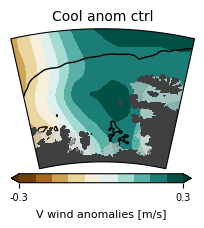

In [36]:
# Set up plot for warm composite
region = 'AS_near' #scale 11, regrid 15
# region = 'full_model_domain' #scale 15, regrid 10

lons, lats = data_2d.lon, data_2d.lat
lat1,lat2,lon1,lon2 = fda.plot_regions[region]
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

fig = plt.figure()
fig.set_size_inches((3,2))
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid)) #eentral_lon =-100 rotates antarctica so pacific is up
data_2d_ma = data_2d.where(data_2d != 0)
cf_em = ax.contourf(lons, lats, data_2d_ma,transform=grid_proj,
                    levels=levs, cmap=cmap, zorder=0, extend = 'both')

plt.title(title + ' anom '+anom_ref, fontsize=10)
bathy_col = 'k' 
q_lon,q_lat = data_x.lon.values, data_x.lat.values
# smaller scale means longer arrows. smaller regrid = fewer arrows.
# quiv = ax.quiver(q_lon,q_lat, data_x.values, data_y.values,
#                  transform = grid_proj,regrid_shape=10,
#                  pivot = 'middle',scale=15,width=0.01,
#                  headlength=3,headaxislength=2.5,
#                  minshaft=1,edgecolor='white',
#                  linewidth = 0.2,zorder=3)
# ax.quiverkey(quiv, X=0.03, Y=0.25, U=vec_len, label=str(vec_len)+' m/s', labelpos='S')

# Add colorbar
cb_ax = fig.add_axes([0.22,0.08,0.6,0.045])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
cb_em.set_label(label = cbar_label, fontsize=8)
cb_em.ax.tick_params(labelsize=7)
cb_em.set_ticks([levs[0],levs[-1]])
cb_em.set_ticklabels([levs[0],levs[-1]])

# Plot bathyemtry and ice and plot
land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
lons,lats = land_ice_ds.lon, land_ice_ds.lat
#blevs = (500,1000)
#ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
# Uncomment to Plot shelf break in thicker line
ax.contour(lons,lats,land_ice_ds.bathy,(1000,),colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)

# Set shape of map to match shape of data rather than a rectangle
rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)
ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

fig.subplots_adjust(left=0.1,right=0.95,top=0.85,bottom=0.15,wspace=0.1,hspace=.05)


In [12]:
# Plot ERA Interim wind relative to 1979-2005

import xarray as xr

erai_dir = '/glade/work/gemmao/MITgcm/forcing/era_interim_annual'
erai_v10_ds = xr.open_dataset(erai_dir+'/annual_v10_1979_2019.nc')
erai_v10 = erai_v10_ds.v10
erai_u10_ds = xr.open_dataset(erai_dir+'/annual_u10_1979_2019.nc')
erai_u10 = erai_u10_ds.u10

# Overlap between simulation, recon, and PACE model
erai_ref_v10 = erai_v10.sel(time=slice('1992','2005')).mean(dim='time')
erai_ref_u10 = erai_u10.sel(time=slice('1992','2005')).mean(dim='time')

erai_v10_anom = erai_v10 - erai_ref_v10
erai_u10_anom = erai_u10 - erai_ref_u10 #(41, 256, 512)

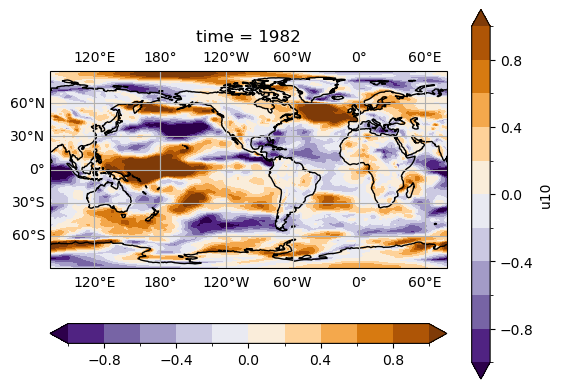

In [13]:
# Plot full ERa Interim U10 large domain
levs = np.linspace(-1,1,11)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
test_data = erai_u10_anom.sel(time=1982)#,lat=slice(-80,-50),lon=slice(180+(180-150),180+(180-60)))
plot = test_data.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels = levs,cmap='PuOr_r')
plt.colorbar(plot,orientation='horizontal',extend='both')
# Add gridlines and coastlines
ax.gridlines(draw_labels=True)
ax.coastlines()

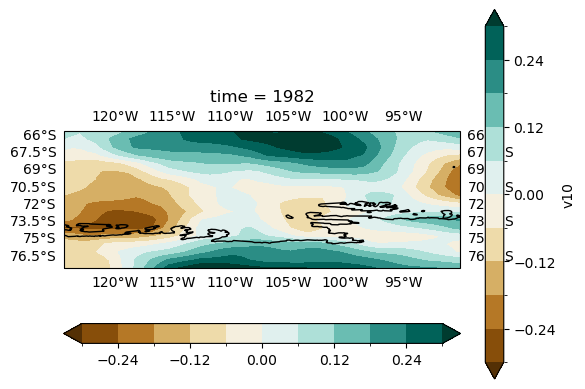

In [14]:
# Plot ERA Interim V10
levs = np.linspace(-0.3,0.3,11)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
test_data = erai_v10_anom.sel(time=1982,lat=slice(-78,-65),lon=slice(180+(180-125),180+(180-90)))
plot = test_data.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels = levs,cmap='BrBG',extend='both')
plt.colorbar(plot,orientation='horizontal',extend='both')
# Add gridlines and coastlines
ax.gridlines(linewidth=0,draw_labels=True)
ax.coastlines()

In [15]:
# calcul era interim mags
mag_erai = (erai_u10_anom ** 2 + erai_v10_anom ** 2) ** 0.5

# #mask small values and large values (Nan where condition is met)
# mask = (mag_em < 0.01) | (mag_em > 0.1) # scale = .35
# mask = (mag_erai < 0.3) 
# erai_u10_anom_masked = erai_u10_anom.where(~mask)
# erai_v10_anom_masked = erai_v10_anom.where(~mask)

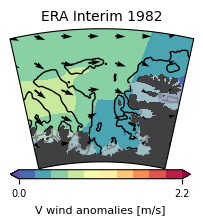

In [16]:
# Plot ERA Interim
region = 'AS_near'
# region = 'full_model_domain'


year = 1982

# Plot v as colors
# data_2d = erai_v10_anom.sel(time=year)
# levs = np.linspace(-0.5,0.5,11)
# cmap = 'BrBG'

# plot mag as colors
data_2d = mag_erai.sel(time=year)
levs = np.linspace(0,2.2,11)
cmap = 'Spectral_r'

data_x = erai_u10_anom.sel(time=year).squeeze()
data_y = erai_v10_anom.sel(time=year).squeeze()

# Set up 1940s event plots
lons, lats = data_2d.lon, data_2d.lat
lat1,lat2,lon1,lon2 = fda.plot_regions[region]
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

fig = plt.figure()
fig.set_size_inches((3,2))
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid)) #eentral_lon =-100 rotates antarctica so pacific is up
data_2d_ma = data_2d.where(data_2d != 0)
cf_em = ax.contourf(lons, lats, data_2d_ma,transform=grid_proj,
                    levels=levs, cmap=cmap, zorder=0, extend = 'both')
plt.title('ERA Interim '+ str(year), fontsize=10)
bathy_col = 'k' 

# plot quivers
q_lon,q_lat = data_x.lon.values, data_x.lat.values
vec_len = 0.5
# smaller scale means longer arrows. smaller regrid = fewer arrows.
quiv = ax.quiver(q_lon,q_lat, data_x.values, data_y.values,
                 transform = grid_proj,zorder=5,
                 scale=9.5,regrid_shape=700,width=0.01)
                 # ,regrid_shape=15,
                 # pivot = 'middle',scale=5,width=0.05,
                 # headlength=3,headaxislength=2.5,
                 # minshaft=1,edgecolor='white',
                 # linewidth = 0.2,zorder=5)
# ax.quiverkey(quiv, X=0.025, Y=0.0, U=vec_len, label=str(vec_len)+' m/s', labelpos='S')
             
# Add colorbar
cb_ax = fig.add_axes([0.22,0.1,0.6,0.045])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
cb_em.set_label(label = cbar_label, fontsize=8)
cb_em.ax.tick_params(labelsize=7)
cb_em.set_ticks([levs[0],levs[-1]])
cb_em.set_ticklabels([levs[0],levs[-1]])

# Plot bathyemtry and ice and plot
land_ice_ds_reg = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
lons,lats = land_ice_ds_reg.lon, land_ice_ds_reg.lat
#blevs = (500,1000)
#ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
# Uncomment to Plot shelf break in thicker line
ax.contour(lons,lats,land_ice_ds_reg.bathy,(500,),colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
ax.contourf(lons,lats,land_ice_ds_reg.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
ax.contourf(lons,lats,land_ice_ds_reg.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)

# Set shape of map to match shape of data rather than a rectangle
rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)
ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

fig.subplots_adjust(left=0.1,right=0.95,top=0.85,bottom=0.15,wspace=0.1,hspace=.05)


In [4]:
import xarray as xr

pace2_dir = '/glade/work/gemmao/ASE_winds/PAC_PACE2/'
pace2_v10_ds = xr.open_dataset(pace2_dir+'V/annual_v10_PAC_PACE2_ens_mean_1880_2014.nc')
pace2_v10 = pace2_v10_ds.v10
pace2_u10_ds = xr.open_dataset(pace2_dir+'U/annual_u10_PAC_PACE2_ens_mean_1880_2014.nc')
pace2_u10 = pace2_u10_ds.u10

# Overlap between simulation, recon, and PACE model
ref_v10 = pace2_v10.sel(time=slice('1992','2005')).mean(dim='time')
ref_u10 = pace2_u10.sel(time=slice('1992','2005')).mean(dim='time')

#put in anomalies
pace2_v10_anom = pace2_v10 - ref_v10
pace2_u10_anom = pace2_u10 - ref_u10

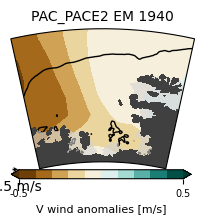

In [12]:
# Plot PACE EM anomalies
cmap = 'BrBG'
# cmap = 'PuOr_r'
levs = np.linspace(-0.5,0.5,11)
year = '1940'
region = 'AS_near'
cbar_label = 'V wind anomalies [m/s]'

#-------------
data_2d = pace2_v10_anom.sel(time=year).squeeze()
data_x = pace2_v10_anom.sel(time=year).squeeze()
data_y = pace2_v10_anom.sel(time=year).squeeze()

# Set up 1940s event plots
lons, lats = data_2d.lon, data_2d.lat
lat1,lat2,lon1,lon2 = fda.plot_regions[region]
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

fig = plt.figure()
fig.set_size_inches((3,2))
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid)) #eentral_lon =-100 rotates antarctica so pacific is up
data_2d_ma = data_2d.where(data_2d != 0)
cf_em = ax.contourf(lons, lats, data_2d_ma,transform=grid_proj,
                    levels=levs, cmap=cmap, zorder=0, extend = 'both')
plt.title('PAC_PACE2 EM '+ year, fontsize=10)
bathy_col = 'k' 

# plot quivers
q_lon,q_lat = data_x.lon.values, data_x.lat.values
# smaller scale means longer arrows. smaller regrid = fewer arrows.
quiv = ax.quiver(q_lon,q_lat, data_x.values, data_y.values,
                 transform = grid_proj,regrid_shape=10,
                 pivot = 'middle',scale=15,width=0.01,
                 headlength=3,headaxislength=2.5,
                 minshaft=1,edgecolor='white',
                 linewidth = 0.2,zorder=3)
vec_len = 0.5
ax.quiverkey(quiv, X=0.025, Y=0.0, U=vec_len, label=str(vec_len)+' m/s', labelpos='S')
             
# Add colorbar
cb_ax = fig.add_axes([0.22,0.1,0.6,0.045])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
cb_em.set_label(label = cbar_label, fontsize=8)
cb_em.ax.tick_params(labelsize=7)
cb_em.set_ticks([levs[0],levs[-1]])
cb_em.set_ticklabels([levs[0],levs[-1]])

# Plot bathyemtry and ice and plot
land_ice_ds = flo.get_bathymetry_and_troughs()
land_ice_ds_reg = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
lons,lats = land_ice_ds_reg.lon, land_ice_ds_reg.lat
#blevs = (500,1000)
#ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
# Uncomment to Plot shelf break in thicker line
ax.contour(lons,lats,land_ice_ds_reg.bathy,(1000,),colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
ax.contourf(lons,lats,land_ice_ds_reg.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
ax.contourf(lons,lats,land_ice_ds_reg.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)

# Set shape of map to match shape of data rather than a rectangle
rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)
ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

fig.subplots_adjust(left=0.1,right=0.95,top=0.85,bottom=0.15,wspace=0.1,hspace=.05)


KeyboardInterrupt: 

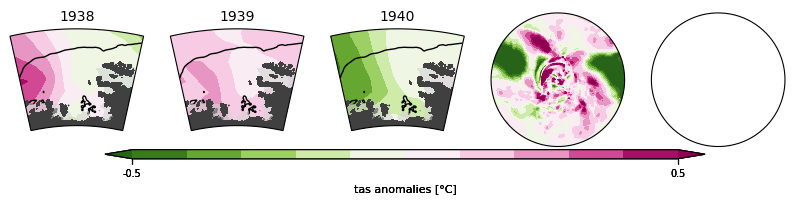

In [10]:
lat1,lat2,lon1,lon2 = fda.plot_regions[region]
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()
land_ice_ds = flo.get_bathymetry_and_troughs()

plot_years = ['1938','1939','1940','1941','1942']
fig,axes = plt.subplots(1,5,figsize=(10,2),
                        subplot_kw={'projection':ccrs.SouthPolarStereo(central_longitude=lon_mid)})
grid_proj = ccrs.PlateCarree()

for i in range(len(plot_years)):
    year = plot_years[i]
    ax = axes[i]
    data_2d = pace2_v10_anom.sel(time=year).squeeze()
    data_x = pace2_u10_anom.sel(time=year).squeeze()
    data_y = pace2_v10_anom.sel(time=year).squeeze()

    # Set up 1940s event plots
    lons, lats = data_2d.lon, data_2d.lat
    lat1,lat2,lon1,lon2 = fda.plot_regions[region]
    lon_mid = (lon1+lon2)/2
    
    data_2d_ma = data_2d.where(data_2d != 0)
    cf_em = ax.contourf(lons, lats, data_2d_ma,transform=grid_proj,
                        levels=levs, cmap=cmap, zorder=0, extend = 'both')
    ax.set_title(year, fontsize=10)
    bathy_col = 'k' 
                 
    # Add colorbar
    cb_ax = fig.add_axes([0.22,0.1,0.6,0.045])
    cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
    cb_em.set_label(label = cbar_label, fontsize=8)
    cb_em.ax.tick_params(labelsize=7)
    cb_em.set_ticks([levs[0],levs[-1]])
    cb_em.set_ticklabels([levs[0],levs[-1]])
    
    # Plot bathyemtry and ice and plot
    land_ice_ds_reg = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
    lons,lats = land_ice_ds_reg.lon, land_ice_ds_reg.lat
    #blevs = (500,1000)
    #ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
    # Uncomment to Plot shelf break in thicker line
    ax.contour(lons,lats,land_ice_ds_reg.bathy,(1000,),colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
    ax.contourf(lons,lats,land_ice_ds_reg.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
    ax.contourf(lons,lats,land_ice_ds_reg.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)
    
    # Set shape of map to match shape of data rather than a rectangle
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

plt.suptitle('PAC_PACE2 EM')
fig.subplots_adjust(left=0.1,right=0.95,top=0.85,bottom=0.15,wspace=0.1,hspace=.05)


In [29]:
# Get recon data
recon_dir = 'Climate_Data/LMR_output/'
# recon = 'PACE_super_GKO1_all_linPSM_1mc_1900_2005_GISBrom_1880_2019_v10_sst'
# recon = 'PAC_PACE2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom'
# recon = 'iCESM_LME_GKO1_linPSM_1mc_1800_2005_v10'
recon='LENS2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom'
recon_short = 'LENS2 recon'

recon_v10_ds = xr.open_dataset(recon_dir+recon+'_v10.nc')
recon_v10 = recon_v10_ds.v10
recon_u10_ds = xr.open_dataset(recon_dir+recon+'_u10.nc')
recon_u10 = recon_u10_ds.u10
recon_tas_ds = xr.open_dataset(recon_dir+recon+'_tas.nc')
recon_tas = recon_tas_ds.tas

ref_v10 = recon_v10.sel(time=slice(1979,2005)).mean(dim='time')
ref_u10 = recon_u10.sel(time=slice(1979,2005)).mean(dim='time')
ref_tas = recon_u10.sel(time=slice(1979,2005)).mean(dim='time')

recon_v10_anom = recon_v10 - ref_v10
recon_u10_anom = recon_u10 - ref_u10
recon_tas_anom = recon_tas - ref_tas

-0.41871172189712524


Text(0.02, 0.05, 'Trend = -0.43 m/s/cent, 1940/41 magnitude = -0.42 m/s')

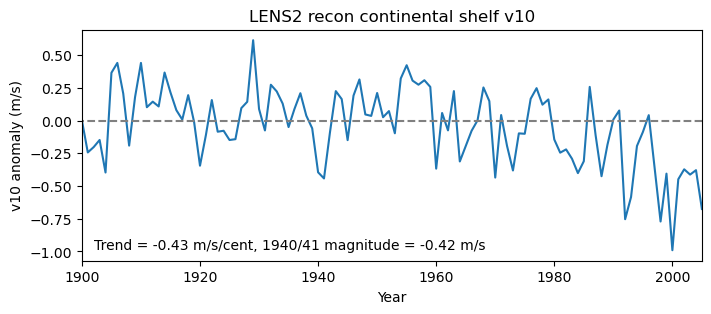

In [30]:
from scipy import stats

# Plot recon timeseries
region = 'AS_near'
lat1,lat2,lon1,lon2 = fda.plot_regions[region]
recon_v10_reg = recon_v10.sel(lat=slice(lat2,lat1),lon=slice(180+(180+lon1),180+(180+lon2)))
recon_v10_reg = recon_v10_reg.squeeze()
recon_v10_tseries = recon_v10_reg.mean(dim='lon')
recon_v10_tseries = recon_v10_tseries.mean(dim='lat')
fig,ax = plt.subplots()
fig.set_size_inches((8,3))
years = recon_v10_tseries.time
ax.plot(years,recon_v10_tseries)
ax.plot(np.arange(1850,2006,1),[0]*156,linestyle='--',color='gray')
ax.set_xlabel('Year')
ax.set_ylabel('v10 anomaly (m/s)')
ax.set_title(recon_short+' continental shelf v10')
ax.set_xlim([1900,2005])

slope, intercept, r_value, p_value, std_err = stats.linregress(years[50:], recon_v10_tseries[50:])
mag_1940s = np.mean(recon_v10_tseries.sel(time=slice(1940,1941)))
print(float(mag_1940s))
text = 'Trend = {:.2f} m/s/cent'.format(slope*100) + ', 1940/41 magnitude = {:.2f} m/s'.format(mag_1940s)
ax.annotate(text, xy=(0.02, 0.05), xycoords='axes fraction')


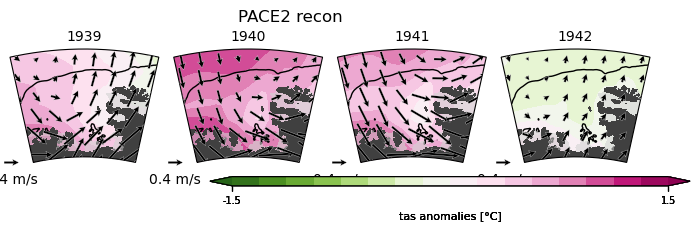

In [35]:
plot_years = [1939,1940,1941,1942]
# plot_years = [1940]
# plot_years = np.arange(1882,1890,1)
# cmap = 'PuOr_r'
cmap = 'PiYG_r'
levs = np.linspace(-1.5,1.5,17)
cbar_label = 'tas anomalies [°C]'

fig,axes = plt.subplots(1,len(plot_years),figsize=(len(plot_years)*2,3),
                        subplot_kw={'projection':ccrs.SouthPolarStereo(central_longitude=lon_mid)})
grid_proj = ccrs.PlateCarree()

for i in range(len(plot_years)):
    year = plot_years[i]
    print(year)
    try:
        ax = axes[i]
    except: 
        ax = axes #if only 1 plot
    data_2d = recon_tas_anom.sel(time=year).squeeze()
    data_x = recon_u10_anom.sel(time=year).squeeze()
    data_y = recon_v10_anom.sel(time=year).squeeze()

    # Set up 1940s event plots
    lons, lats = data_2d.lon, data_2d.lat
    lat1,lat2,lon1,lon2 = fda.plot_regions[region]
    lon_mid = (lon1+lon2)/2
    
    data_2d_ma = data_2d.where(data_2d != 0)
    cf_em = ax.contourf(lons, lats, data_2d_ma,transform=grid_proj,
                        levels=levs, cmap=cmap, zorder=0, extend = 'both')
    ax.set_title(year, fontsize=10)
    bathy_col = 'k' 
    
    # plot quivers
    q_lon,q_lat = data_x.lon.values, data_x.lat.values
    vec_len= 0.4
    # smaller scale means longer arrows. smaller regrid = fewer arrows.
    quiv = ax.quiver(q_lon,q_lat, data_x.values, data_y.values,
                     transform = grid_proj,regrid_shape=800,
                     pivot = 'middle',scale=4,width=0.015,
                     headlength=3,headaxislength=2.5,
                     minshaft=1,edgecolor='white',
                     linewidth = 0.2,zorder=3)
    if i ==0:
        ax.quiverkey(quiv, X=0.01, Y=0.0, U=vec_len, label=str(vec_len)+' m/s', labelpos='S')
                 
    # Add colorbar
    cb_ax = fig.add_axes([0.4,0.1,0.4,0.045])
    cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
    cb_em.set_label(label = cbar_label, fontsize=8)
    cb_em.ax.tick_params(labelsize=7)
    cb_em.set_ticks([levs[0],levs[-1]])
    cb_em.set_ticklabels([levs[0],levs[-1]])
    
    # Plot bathyemtry and ice and plot
    land_ice_ds_reg = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
    lons,lats = land_ice_ds_reg.lon, land_ice_ds_reg.lat
    #blevs = (500,1000)
    #ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
    # Uncomment to Plot shelf break in thicker line
    ax.contour(lons,lats,land_ice_ds_reg.bathy,(1000,),colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
    ax.contourf(lons,lats,land_ice_ds_reg.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
    ax.contourf(lons,lats,land_ice_ds_reg.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)
    
    # Set shape of map to match shape of data rather than a rectangle
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

plt.suptitle(recon_short)
fig.subplots_adjust(left=0.15,right=0.95,top=0.85,bottom=0.2,wspace=0.1,hspace=.05)


In [31]:
from scipy import stats

# Calculate v10 trends
recon_v10_20th = recon_v10.sel(time = slice(1920,2005)).squeeze()
yrs = recon_v10_20th.time.values
n_lats,n_lons = recon_v10_20th.shape[1:]
recon_v10_rs=recon_v10_20th.values.reshape(len(yrs),-1) #now it is shape (n_time, nlons*nlats) 
locs=range(n_lats*n_lons)
v10_trends = []
for loc in locs:
    data_loc = recon_v10_rs[:,loc]
    slope, intercept, r_value, p_value, std_err = stats.linregress(yrs, data_loc)
    v10_trends.append(slope * 100)
v10_trends = np.array(v10_trends)
v10_trends = v10_trends.reshape((n_lats,-1))

In [32]:
# calculate tas trends
recon_tas_ds = xr.open_dataset(recon_dir+recon+'_tas.nc')
recon_tas = recon_tas_ds.tas
recon_tas_20th = recon_tas.sel(time = slice(1920,2005)).squeeze()
yrs = recon_tas_20th.time.values
n_lats,n_lons = recon_tas_20th.shape[1:]
recon_tas_rs=recon_tas_20th.values.reshape(len(yrs),-1) #now it is shape (n_time, nlons*nlats) 
locs=range(n_lats*n_lons)
tas_trends = []
for loc in locs:
    data_loc = recon_tas_rs[:,loc]
    slope, intercept, r_value, p_value, std_err = stats.linregress(yrs, data_loc)
    tas_trends.append(slope * 100)
tas_trends = np.array(tas_trends)
tas_trends = tas_trends.reshape((n_lats,-1))

In [33]:
# Calculate u10 trends
recon_u10_20th = recon_u10.sel(time = slice(1920,2005)).squeeze()
yrs = recon_u10_20th.time.values
n_lats,n_lons = recon_u10_20th.shape[1:]
recon_u10_rs=recon_u10_20th.values.reshape(len(yrs),-1) #now it is shape (n_time, nlons*nlats) 
locs=range(n_lats*n_lons)
u10_trends = []
for loc in locs:
    data_loc = recon_u10_rs[:,loc]
    slope, intercept, r_value, p_value, std_err = stats.linregress(yrs, data_loc)
    u10_trends.append(slope * 100)
u10_trends = np.array(u10_trends)
u10_trends = u10_trends.reshape((n_lats,-1))

In [14]:
land_ice_ds = flo.get_bathymetry_and_troughs()

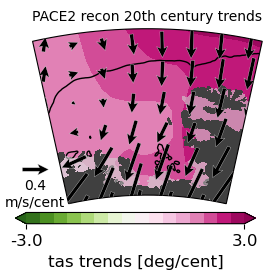

In [34]:
# Plot 20th century trends
# Plot PACE EM anomalies
cmap = 'PiYG_r'#'BrBG'
levs = np.linspace(-3,3,17) #np.linspace(-0.5,0.5,11)
region = 'AS_near'
cbar_label = 'tas trends [deg/cent]'
data_2d = tas_trends #v10_trends

#-------------


lons, lats = recon_v10.lon, recon_v10.lat
lat1,lat2,lon1,lon2 = fda.plot_regions[region]
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

fig = plt.figure()
fig.set_size_inches((4,2.5))
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid)) #eentral_lon =-100 rotates antarctica so pacific is up
cf_em = ax.contourf(lons, lats,data_2d,transform=grid_proj,
                    levels=levs, cmap=cmap, zorder=0, extend = 'both')
plt.title(recon_short+' 20th century trends', fontsize=10)
bathy_col = 'k' 

# plot quivers
# smaller scale means longer arrows. smaller regrid = fewer arrows.
quiv = ax.quiver(lons,lats, u10_trends, v10_trends,
                 transform = grid_proj,regrid_shape=800,
                 pivot = 'middle',scale=3.5,width=0.016,
                 headlength=3,headaxislength=2.5,
                 minshaft=1,edgecolor='white',
                 linewidth = 0.2,zorder=3)
vec_len = 0.4
ax.quiverkey(quiv, X=0.01, Y=0.2, U=vec_len, label=str(vec_len)+'\nm/s/cent', labelpos='S')

# Add colorbar
cb_ax = fig.add_axes([0.22,0.07,0.6,0.045])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
cb_em.set_label(label = cbar_label, fontsize=12)
cb_em.ax.tick_params(labelsize=12)
cb_em.set_ticks([levs[0],levs[-1]])
cb_em.set_ticklabels([levs[0],levs[-1]])

# Plot bathyemtry and ice and plot
land_ice_ds_reg = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
lons,lats = land_ice_ds_reg.lon, land_ice_ds_reg.lat
#blevs = (500,1000)
#ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
# Uncomment to Plot shelf break in thicker line
ax.contour(lons,lats,land_ice_ds_reg.bathy,(1000,),colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
ax.contourf(lons,lats,land_ice_ds_reg.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
ax.contourf(lons,lats,land_ice_ds_reg.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)

# Set shape of map to match shape of data rather than a rectangle
rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)
ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

fig.subplots_adjust(left=0.15,right=0.95,top=0.85,bottom=0.15,wspace=0.1,hspace=.05)
